In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

Set working directory

In [2]:
dataDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/Sox9/WT/'
inputDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/input/SOX9/'
workingDirectory = '/home/h1bennet/brain_aging/results/03_Sox9_H3K27Ac/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

# Read in raw peak files

In [4]:
df, mat = read_annotated_peaks('./annotated_peaks/ann_raw_idr_nfr_peaks_merged.txt')
df.index.rename('PeakID', inplace=True)
# # OPTIONAL: drop bad qc samples
# tst = np.append(np.asarray([True]*18, 'bool'), mat.columns.str.contains('|'.join(best_reps)))
# df = df.loc[:, tst]
# mat = mat.loc[:, mat.columns.str.contains('|'.join(best_reps))]

df.to_csv('./annotated_peaks/ann_raw_idr_nfr_peaks_merged_filtered.txt', sep='\t')

In [5]:
mat.columns.str.split('/').str[-1]

Index(['00_mouse_BL6_M_10day_SOX9_ChIP_H3K27ac_1_AL_20200610_ATTATCAA_CGACTCTC',
       '00_mouse_BL6_M_10day_SOX9_ChIP_H3K27ac_2_AL_20200610_GACCAGGA_CTGGCTAT',
       '01_mouse_BL6_M_3week_SOX9_ChIP_H3K27ac_1_AL_l20200911_CATAGAGT_TGCCACCA',
       '01_mouse_BL6_M_3week_SOX9main_ChIP_H3K27ac_2_AL_l20200925_AGTACTCC_AACCTGTT',
       '02_mouse_BL6_M_3month_SOX9_ChIP_H3K27ac_2_AL_20200205_AGTCAA',
       '03_mouse_MPSIIIAhet_M_4month_SOX9_ChIP_H3K27ac_1_AL_20200925_CATAGAGT_TGCCACCA',
       '03_mouse_MPSIIIAhet_M_4month_SOX9_ChIP_H3K27ac_2_AL_20201121_AATGCCTC_TCGATCCA'],
      dtype='object')

# Run differential peak analysis

In [6]:
%%bash
source activate deseq_36
getDiffExpression.pl ./annotated_peaks/ann_raw_idr_nfr_peaks_merged_filtered.txt \
00_sox9_10day 00_sox9_10day \
01_sox9_3week 01_sox9_3week \
02_sox9_4month 02_sox9_4month 02_sox9_4month \
-peaks > ./diff_nfr_output.txt

	Treating input as file generated by annotatePeaks.pl (-peaks)

	Performing variance stabalization (rlog)...



	Using DESeq2 to calculate differential expression/enrichment...
	Output Stats 00_sox9_10day vs. 01_sox9_3week:
		Total Genes: 74460
		Total Up-regulated in 01_sox9_3week vs. 00_sox9_10day: 130 (0.175%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in 01_sox9_3week vs. 00_sox9_10day: 9 (0.012%) [log2fold<-1, FDR<0.05]
	Output Stats 00_sox9_10day vs. 02_sox9_4month:
		Total Genes: 74460
		Total Up-regulated in 02_sox9_4month vs. 00_sox9_10day: 11670 (15.673%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in 02_sox9_4month vs. 00_sox9_10day: 10050 (13.497%) [log2fold<-1, FDR<0.05]



In [7]:
%%bash
source activate deseq_36
getDiffExpression.pl ./annotated_peaks/ann_raw_idr_nfr_peaks_merged_filtered.txt \
00_sox9_young 00_sox9_young \
00_sox9_young 00_sox9_young \
02_sox9_old 02_sox9_old 02_sox9_old \
-peaks > ./diff_nfr_output_youngpool.txt

	Treating input as file generated by annotatePeaks.pl (-peaks)

	Performing variance stabalization (rlog)...



	Using DESeq2 to calculate differential expression/enrichment...
	Output Stats 00_sox9_young vs. 02_sox9_old:
		Total Genes: 74460
		Total Up-regulated in 02_sox9_old vs. 00_sox9_young: 892 (1.198%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in 02_sox9_old vs. 00_sox9_young: 2140 (2.874%) [log2fold<-1, FDR<0.05]



# Create summary plots

## 10day vs. 4 months

In [9]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './diff_nfr_output.txt',
    './annotated_peaks/ann_raw_idr_nfr_peaks_merged.txt')
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')

annotatePeaks all peaks (75991, 25)
getDiffExpression selected transcripts (74460, 31)
annotatePeaks selected peaks (74460, 25)


In [10]:
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')

In [11]:
comps = ['00_sox9_10day vs. 02_sox9_4month']

cols = [[0,1,4,5,6]]

groups = [[[0,1],[4,5,6]]]

colors = [['#3182bd', '#de2d26']]

00_sox9_10day vs. 02_sox9_4month
N genes downregulated 10050
N genes upregulated 11670



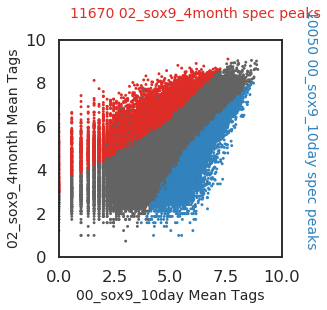

In [12]:
fc = np.log2(2)
pval = 0.05

for key, col, group, color in zip(comps, cols, groups, colors):
#     print(key)
#     print('mean calculated using tag dirs:')
#     for colid in peak_mat.iloc[:, col].columns.tolist():
#         print(colid)
#     print('')

    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
    dot_colors = []
    dot_sizes = []
    for index, row in de.iterrows():
        if (row.adj_pval <= pval) & (-row.log2fc < -fc):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= pval) & (-row.log2fc > fc):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('#636363')
            dot_sizes.append(0.5)
    print(key)
    print('N genes downregulated', np.sum((de.adj_pval <= pval) & (de.log2fc < -fc)))
    print('N genes upregulated', np.sum((de.adj_pval <= pval) & (de.log2fc > fc)))
    print('')

    fig, ax = plt.subplots(figsize=(4,4))
    # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=2, #de.log10p+0.05,
        c=dot_colors)

    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags', fontsize=14)
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags', fontsize=14)
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
    ax.text(0.5,11,
        s='%d %s spec peaks' % (np.sum((de.adj_pval <= pval) & (de.log2fc > fc)), key.split(' vs. ')[1]),
        fontsize=14,
        c=color[1])
    ax.text(11,0.5,
        s='%d %s spec peaks' % (np.sum((de.adj_pval <= pval) & (de.log2fc < -fc)), key.split(' vs. ')[0]),
        fontsize=14,
        c=color[0],
        rotation=-90)
    
    plt.savefig('./figures/'+key+'_scatter.png', bbox_inches='tight')
    # plt.close()

## Pooled young (10 day and 21 day) vs. 4 month

In [13]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './diff_fw_output_youngpool.txt',
    './annotated_peaks/ann_raw_idr_fw_peaks_merged.txt')
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')

annotatePeaks all peaks (32143, 25)
getDiffExpression selected transcripts (31410, 28)
annotatePeaks selected peaks (31410, 25)


In [14]:
comp_dict.keys()

dict_keys(['00_sox9_young vs. 02_sox9_old'])

In [15]:
comps = ['00_sox9_young vs. 02_sox9_old']

cols = [[0,1,2,3,4,5,6]]

groups = [[[0,1,2,3],[4,5,6]]]

colors = [['#3182bd', '#de2d26']]

00_sox9_young vs. 02_sox9_old
N genes downregulated 680
N genes upregulated 340



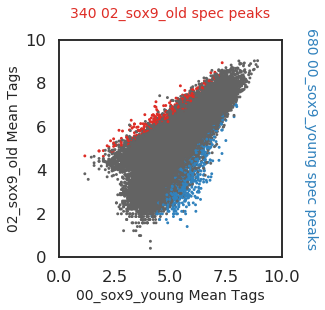

In [16]:
fc = np.log2(2)
pval = 0.05

for key, col, group, color in zip(comps, cols, groups, colors):
#     print(key)
#     print('mean calculated using tag dirs:')
#     for colid in peak_mat.iloc[:, col].columns.tolist():
#         print(colid)
#     print('')

    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
    dot_colors = []
    dot_sizes = []
    for index, row in de.iterrows():
        if (row.adj_pval <= pval) & (-row.log2fc < -fc):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= pval) & (-row.log2fc > fc):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('#636363')
            dot_sizes.append(0.5)
    print(key)
    print('N genes downregulated', np.sum((de.adj_pval <= pval) & (de.log2fc < -fc)))
    print('N genes upregulated', np.sum((de.adj_pval <= pval) & (de.log2fc > fc)))
    print('')
    fig, ax = plt.subplots(figsize=(4,4))
    
    # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=2, #de.log10p+0.05,
        c=dot_colors)

    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags', fontsize=14)
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags', fontsize=14)
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
    ax.text(0.5,11,
        s='%d %s spec peaks' % (np.sum((de.adj_pval <= pval) & (de.log2fc > fc)), key.split(' vs. ')[1]),
        fontsize=14,
        c=color[1])
    ax.text(11,0.5,
        s='%d %s spec peaks' % (np.sum((de.adj_pval <= pval) & (de.log2fc < -fc)), key.split(' vs. ')[0]),
        fontsize=14,
        c=color[0],
        rotation=-90)
    
    plt.savefig('./figures/'+key+'_youngpool_scatter.png', bbox_inches='tight')
    # plt.close()

# Looking at this we will proceed with an analysis of the 10 day and 4 month data.

In [21]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './diff_nfr_output.txt',
    './annotated_peaks/ann_raw_idr_nfr_peaks_merged.txt')
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')

annotatePeaks all peaks (75991, 25)
getDiffExpression selected transcripts (74460, 31)
annotatePeaks selected peaks (74460, 25)


In [22]:
comp_dict.keys()

dict_keys(['00_sox9_10day vs. 01_sox9_3week', '00_sox9_10day vs. 02_sox9_4month'])

# Extract peaks for an analysis in GREAT

In [23]:
# initialize dict and list of cell types
peak_lists = {}
cells = ['00_sox9_10day', '02_sox9_4month']

# set pvalue and fc thresholds
fc = np.log2(2)
pval = 0.05

for cell in cells:
    print('Analyzing', cell, '...\n')
    
    # set count
    count = 0
    
    for key in comp_dict.keys():
        
        # select get diff data frame.
        df = comp_dict[key]
        
        # check on counter
        print(count)


        # initialize lists if count == 0
        if count == 0:
            # fold change direction depends on the location of the cell in the comparison.
            # if cell is in first position it is reference - so negative log2fc is higher in first position
            if cell in key.split(' vs. ')[0]:
                u = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                i = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                count = count + 1
            # if cell is in second position it is comparison - so positive log2fc is higher in second position
            elif cell in key.split(' vs. ')[1]:
                u = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                i = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                count = count + 1

        else:
            # fold change direction depends on the location of the cell in the comparison.
            # if cell is in first position it is reference - so negative log2fc is higher in first position
            if cell in key.split(' vs. ')[0]:
                u = u.union(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                i = i.intersection(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                count = count + 1
            # if cell is in second position it is comparison - so positive log2fc is higher in second position
            elif cell in key.split(' vs. ')[1]:
                u = u.union(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                i = i.intersection(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                count = count + 1

        
        # summarize iteration
        print('For comp:', key)
        print('Union set at:', len(u), 'peaks')
        print('Intersection set at:', len(i), 'peaks\n')
     
    
        # store lists
        peak_lists[cell+'_union'] = u
        peak_lists[cell+'_intersection'] = i

Analyzing 00_sox9_10day ...

0
For comp: 00_sox9_10day vs. 01_sox9_3week
Union set at: 9 peaks
Intersection set at: 9 peaks

1
For comp: 00_sox9_10day vs. 02_sox9_4month
Union set at: 10050 peaks
Intersection set at: 9 peaks

Analyzing 02_sox9_4month ...

0
For comp: 00_sox9_10day vs. 01_sox9_3week
Union set at: 10050 peaks
Intersection set at: 9 peaks

0
For comp: 00_sox9_10day vs. 02_sox9_4month
Union set at: 11670 peaks
Intersection set at: 11670 peaks



### Save peak and bed files for GREAT analysis (this might be better to do with the larger variable width or fixed width regions)

In [24]:
if not os.path.isdir('./great_analysis/'):
    os.mkdir('./great_analysis/')
    
if not os.path.isdir('./great_analysis/peak_files/'):
    os.mkdir('./great_analysis/peak_files/')
    
if not os.path.isdir('./great_analysis/bed_files/'):
    os.mkdir('./great_analysis/bed_files/')

Save each set of peaks derived from the list - in this case its just one set activated in each group

In [25]:
for key in peak_lists.keys():
    # save cell specific promoters
    diff_peak.reindex(peak_lists[key]).dropna(how='all').iloc[:, :4].to_csv(
        './great_analysis/peak_files/'+key+'_act_nfr_peaks.txt',
        sep='\t')

Save full set of peaks for background

In [26]:
diff_peak.iloc[:, :4].to_csv(
    './great_analysis/peak_files/sox9_all_nfr_peaks.txt',
    sep='\t')

Convert to bed files

In [27]:
%%bash
# delete the existing script file
rm ./peak_to_bed_great.sh
# create a script file
touch ./peak_to_bed_great.sh

In [28]:
%%bash
for peakfile in ./great_analysis/peak_files/*txt;
do bedfile=${i/act/bg};
out=${peakfile/.txt/.bed};
out=${out/peak_files/bed_files}
echo "pos2bed.pl -o $out $peakfile" >> ./peak_to_bed_great.sh
done

# Create bed files for visualization in browser

In [34]:
if not os.path.isdir('./bed_files/'):
    os.mkdir('./bed_files/')

In [35]:
!cp ./great_analysis/bed_files/*union* ./bed_files/

In [36]:
!ls ./bed_files/

00_sox9_10day_union_act_nfr_peaks.bed	nfrmd2000_peaks_merg
00_sox9_10day_union_act_peaks.bed	nfrmd2000_peaks_merged.bed
02_sox9_4month_union_act_nfr_peaks.bed	nfrmd_peaks_merged.bed
02_sox9_4month_union_act_peaks.bed	nfr_peaks_merged.bed
fw_peaks_merged.bed			vw_peaks_merged.bed
nfrmd1000_peaks_merged.bed


Give track names for uploading to genome browser

In [31]:
%%bash

echo 'track name="Sox9_H3K27Ac_10day_peaks" description="Sox9 Nuclei 10day H3K27Ac Chip-seq DESeq2 specific peaks"' \
| cat - ./bed_files/00_sox9_10day_union_act_peaks.bed \
> temp && mv temp ./bed_files/00_sox9_10day_union_act_peaks.bed

echo 'track name="Sox9_H3K27Ac_4month_peaks" description="Sox9 Nuclei 4month H3K27Ac Chip-seq DESeq2 specific peaks"' \
| cat - ./bed_files/02_sox9_4month_union_act_peaks.bed \
> temp && mv temp ./bed_files/02_sox9_4month_union_act_peaks.bed

Next step... check these peaks on browser to make sure they look specific

In [37]:
# make location column for peak dict (for examining on browser)
diff_peak['location'] = diff_peak.Chr + ':' + diff_peak.Start.map(str) + '-' + diff_peak.End.map(str)

In [38]:
diff_peak.sort_values('00_sox9_10day vs. 02_sox9_4month adj. p-value', ascending=True).head(10)

,Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,Nearest PromoterID,...,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/Sox9/WT/02_mouse_BL6_M_3month_SOX9_ChIP_H3K27ac_2_AL_20200205_AGTCAA,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/Sox9/WT/03_mouse_MPSIIIAhet_M_4month_SOX9_ChIP_H3K27ac_1_AL_20200925_CATAGAGT_TGCCACCA,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/Sox9/WT/03_mouse_MPSIIIAhet_M_4month_SOX9_ChIP_H3K27ac_2_AL_20201121_AATGCCTC_TCGATCCA,00_sox9_10day vs. 01_sox9_3week Log2 Fold Change,00_sox9_10day vs. 01_sox9_3week p-value,00_sox9_10day vs. 01_sox9_3week adj. p-value,00_sox9_10day vs. 02_sox9_4month Log2 Fold Change,00_sox9_10day vs. 02_sox9_4month p-value,00_sox9_10day vs. 02_sox9_4month adj. p-value,location
PeakID,,,,,,,,,,,,,,,,,,,,,
Merged-chr7-17060281-2,chr7,17059771,17060771,+,70.050003,./peak_files/00_mouse_BL6_M_10day_SOX9_ChIP_H3...,"intron (NM_001162950, intron 1 of 14)","intron (NM_001162950, intron 1 of 14)",2156.0,NM_001162950,...,8.124090,8.508751,8.663787,3.038944,8.525270e-09,0.000195,3.090577,1.006863e-30,7.497103e-26,chr7:17059771-17060771
Merged-chr4-139967202-1,chr4,139966702,139967702,+,28.700001,./peak_files/02_mouse_BL6_M_3month_SOX9_ChIP_H...,TTS (NR_035519),TTS (NR_035519),418.0,NR_035519,...,7.478177,8.004414,7.990415,2.929379,4.090608e-05,0.032670,4.131242,5.748289e-29,2.140088e-24,chr4:139966702-139967702
Merged-chr7-4112739-3,chr7,4112228,4113228,+,72.266663,./peak_files/01_mouse_BL6_M_3week_SOX9_ChIP_H3...,"intron (NR_033568, intron 2 of 8)","intron (NR_033568, intron 2 of 8)",-6802.0,NM_001109765,...,7.665232,7.930267,8.269514,2.905525,1.876888e-06,0.006139,3.561136,2.820102e-27,6.999494e-23,chr7:4112228-4113228
Merged-chr1-182484631-1,chr1,182484131,182485131,+,46.500000,./peak_files/02_mouse_BL6_M_3month_SOX9_ChIP_H...,"intron (NM_009794, intron 9 of 20)",ID_B1|SINE|B4,32979.0,NM_009794,...,8.056314,8.410646,8.446895,2.418646,6.322416e-05,0.039638,2.787666,4.072434e-27,7.580836e-23,chr1:182484131-182485131
Merged-chr15-82379463-1,chr15,82378963,82379963,+,122.800003,./peak_files/03_mouse_MPSIIIAhet_M_4month_SOX9...,"intron (NM_019823, intron 1 of 9)","intron (NM_019823, intron 1 of 9)",797.0,NM_019823,...,7.805389,8.201942,8.342175,2.515996,7.059629e-05,0.042164,3.421146,6.198137e-27,9.230265e-23,chr15:82378963-82379963
Merged-chr14-57133043-3,chr14,57132530,57133530,+,63.833332,./peak_files/01_mouse_BL6_M_3week_SOX9_ChIP_H3...,"intron (NM_001010937, intron 1 of 2)",CpG,581.0,NM_001271663,...,8.344585,8.617428,8.616810,1.337859,1.066282e-02,0.430803,2.372797,8.900548e-27,1.104558e-22,chr14:57132530-57133530
Merged-chr6-31455027-5,chr6,31454530,31455530,+,54.900002,./peak_files/01_mouse_BL6_M_3week_SOX9_ChIP_H3...,"intron (NM_013791, intron 8 of 17)","intron (NM_013791, intron 8 of 17)",56202.0,NM_013791,...,7.537516,7.560963,7.905657,3.357792,4.027601e-07,0.002128,3.811141,1.995696e-26,2.122851e-22,chr6:31454530-31455530
Merged-chr7-144939818-2,chr7,144939315,144940315,+,40.099998,./peak_files/00_mouse_BL6_M_10day_SOX9_ChIP_H3...,"5' UTR (NM_007631, exon 1 of 5)","5' UTR (NM_007631, exon 1 of 5)",110.0,NM_007631,...,3.977969,4.122933,4.244844,-1.889466,8.417682e-03,0.395155,-4.285749,2.900689e-26,2.699816e-22,chr7:144939315-144940315
Merged-chr4-139966872-1,chr4,139966372,139967372,+,62.700001,./peak_files/03_mouse_MPSIIIAhet_M_4month_SOX9...,TTS (NR_035519),TTS (NR_035519),748.0,NR_035519,...,7.309577,7.721109,7.837157,3.028218,9.522713e-05,0.048093,4.048097,7.606513e-26,6.293122e-22,chr4:139966372-139967372


At this enhancer we can see that the fixed width peak does in fact miss the nucleosome free region associated with the enhancer - so theoretically would miss the motif as well.
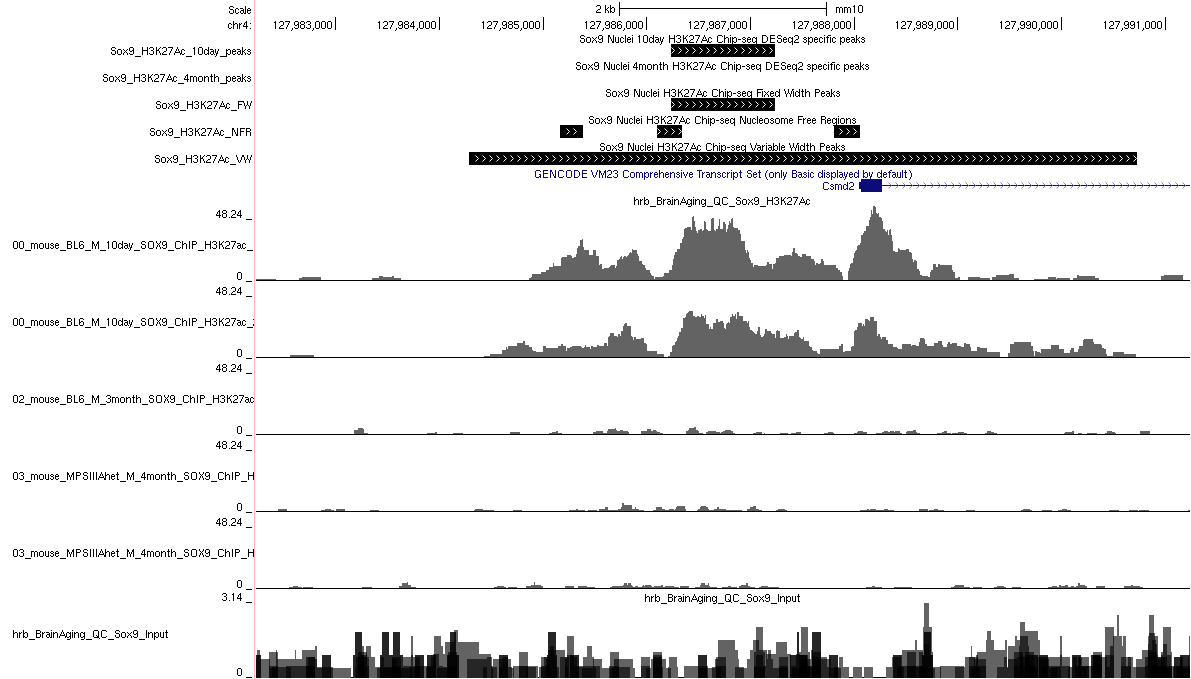
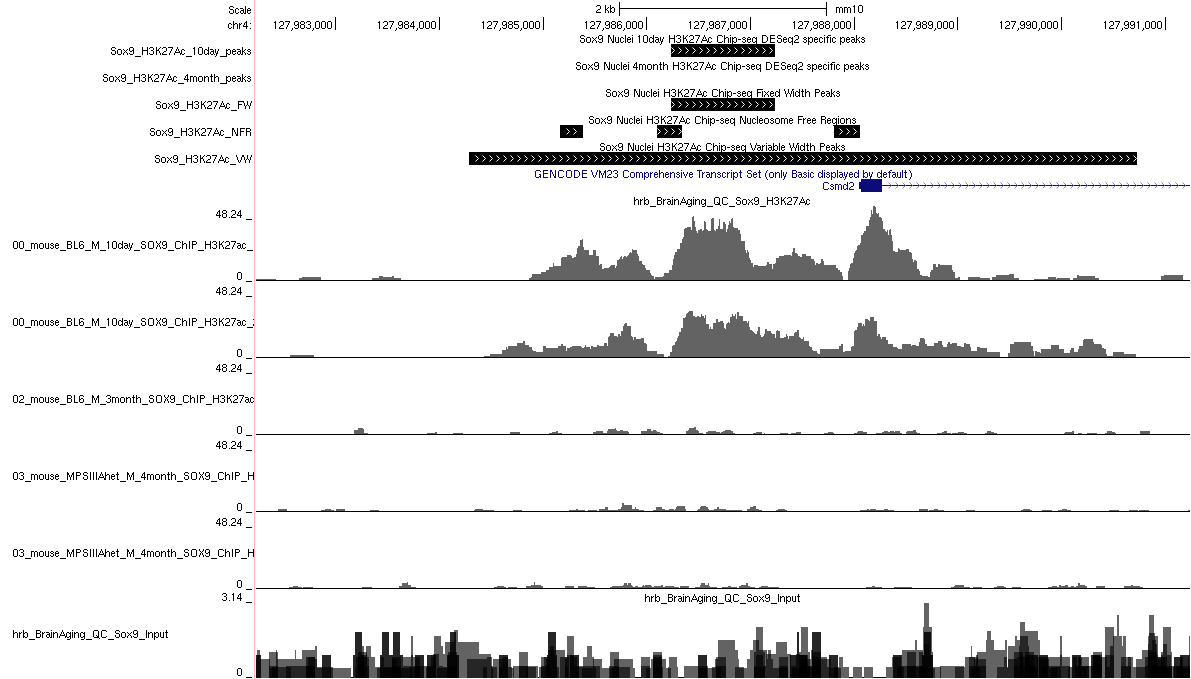